<a href="https://colab.research.google.com/github/FahadNisarSE/Computer-Vision/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Sound Project

## Installing Dependencies

In [ ]:
!pip install tensorflow tensorflow-io matplotlib

## 1. Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

## 2. Build Data Loading Function

### 2.1. Define Paths to our files

In [ ]:
CORONA_FILE = os.path.join('/content/drive/MyDrive/samples/Coronoa/Corona (1).wav')
ARCH_FILE = os.path.join('/content/drive/MyDrive/samples/Coronoa/Corona (1).wav')

### 2.2. Data Loading Fnctions

In [ ]:
def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_content = tf.io.read_file(filename)
  # Decode wav (tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
  # remove trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Goes from 44100HX to 16000hz - amplitude of the audio signal
  wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out=16000)
  return wav

### 2.3. Plotting Wave

In [ ]:
wave_corona = load_wav_16k_mono(CORONA_FILE)
wave_arc = load_wav_16k_mono(ARCH_FILE)

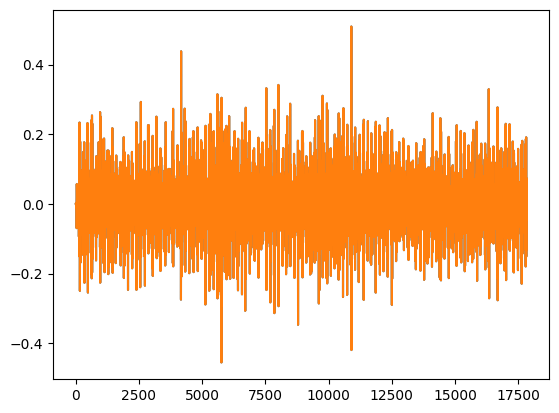

In [ ]:
plt.plot(wave_corona)
plt.plot(wave_arc)
plt.show()

## 3. Creating TensorFlow Dataset

### 3.1 Define Paths to Corona, Tracking, Loseness and Arcing Data

In [ ]:
COROANA_FILE_PATH = os.path.join('/content/drive/MyDrive/samples/Coronoa')
TRACKING_FILE_PATH = os.path.join('/content/drive/MyDrive/samples/Tracking')
LOSENESS_FILE_PATH = os.path.join('/content/drive/MyDrive/samples/Looseness')
ARCING_FILE_PATH = os.path.join('/content/drive/MyDrive/samples/Arcing')

### 3.2 Create Tensorflow Dataset

In [ ]:
CORONA_FILES = tf.data.Dataset.list_files(COROANA_FILE_PATH+'/*.wav');
TRACKING_FILES = tf.data.Dataset.list_files(TRACKING_FILE_PATH+'/*.wav');
LOSENESS_FILES = tf.data.Dataset.list_files(LOSENESS_FILE_PATH+'/*.wav');
ARCING_FILES = tf.data.Dataset.list_files(ARCING_FILE_PATH+'/*.wav');

3.3. Add Labels and Combine Corona, Tracking, Loseness and Arcing

In [ ]:
corona = tf.data.Dataset.zip((CORONA_FILES, tf.data.Dataset.from_tensor_slices(np.full(len(CORONA_FILES), 0))))
tracking = tf.data.Dataset.zip((TRACKING_FILES, tf.data.Dataset.from_tensor_slices(np.full(len(TRACKING_FILES), 1))))
loseness = tf.data.Dataset.zip((LOSENESS_FILES, tf.data.Dataset.from_tensor_slices(np.full(len(LOSENESS_FILES), 2))))
arcing = tf.data.Dataset.zip((ARCING_FILES, tf.data.Dataset.from_tensor_slices(np.full(len(ARCING_FILES), 3))))

3.4. Conactinate all the data

In [ ]:
combined_dataset = corona.concatenate(tracking).concatenate(loseness).concatenate(arcing)

## 4. Determine the Average Length of Audio Signal

### 4.1. Calculate Wave Cylce Length

In [ ]:
coro_file_lengths = []

for corona_file in CORONA_FILES:
    tensor_wave = load_wav_16k_mono(corona_file)
    coro_file_lengths.append(len(tensor_wave))

tracking_file_lengths = []

for tracking_file in TRACKING_FILES:
    tensor_wave = load_wav_16k_mono(tracking_file)
    tracking_file_lengths.append(len(tensor_wave))

loseness_file_lengths = []

for loseness_file in LOSENESS_FILES:
    tensor_wave = load_wav_16k_mono(loseness_file)
    loseness_file_lengths.append(len(tensor_wave))

arcing_file_lengths = []

for loseness_file in ARCING_FILES:
    tensor_wave = load_wav_16k_mono(loseness_file)
    arcing_file_lengths.append(len(tensor_wave))

### 4.2 Calculate mean, min and max

In [ ]:
tf.math.reduce_mean(arcing_file_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=471085>

In [ ]:
tf.math.reduce_max(arcing_file_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=820314>

In [ ]:
tf.math.reduce_min(arcing_file_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=148607>

## 5. Build Preprocessing Function to Conver to Spectogram

### 5.1. Build Preprocessing Funciton

In [ ]:
def preprocessor(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:552084]
    zero_padding = tf.zeros([552084] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5.2 Test Out the Funciton and Viz the Spectrogram

In [ ]:
filepath, label = combined_dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocessor(filepath, label)

In [ ]:
label

0

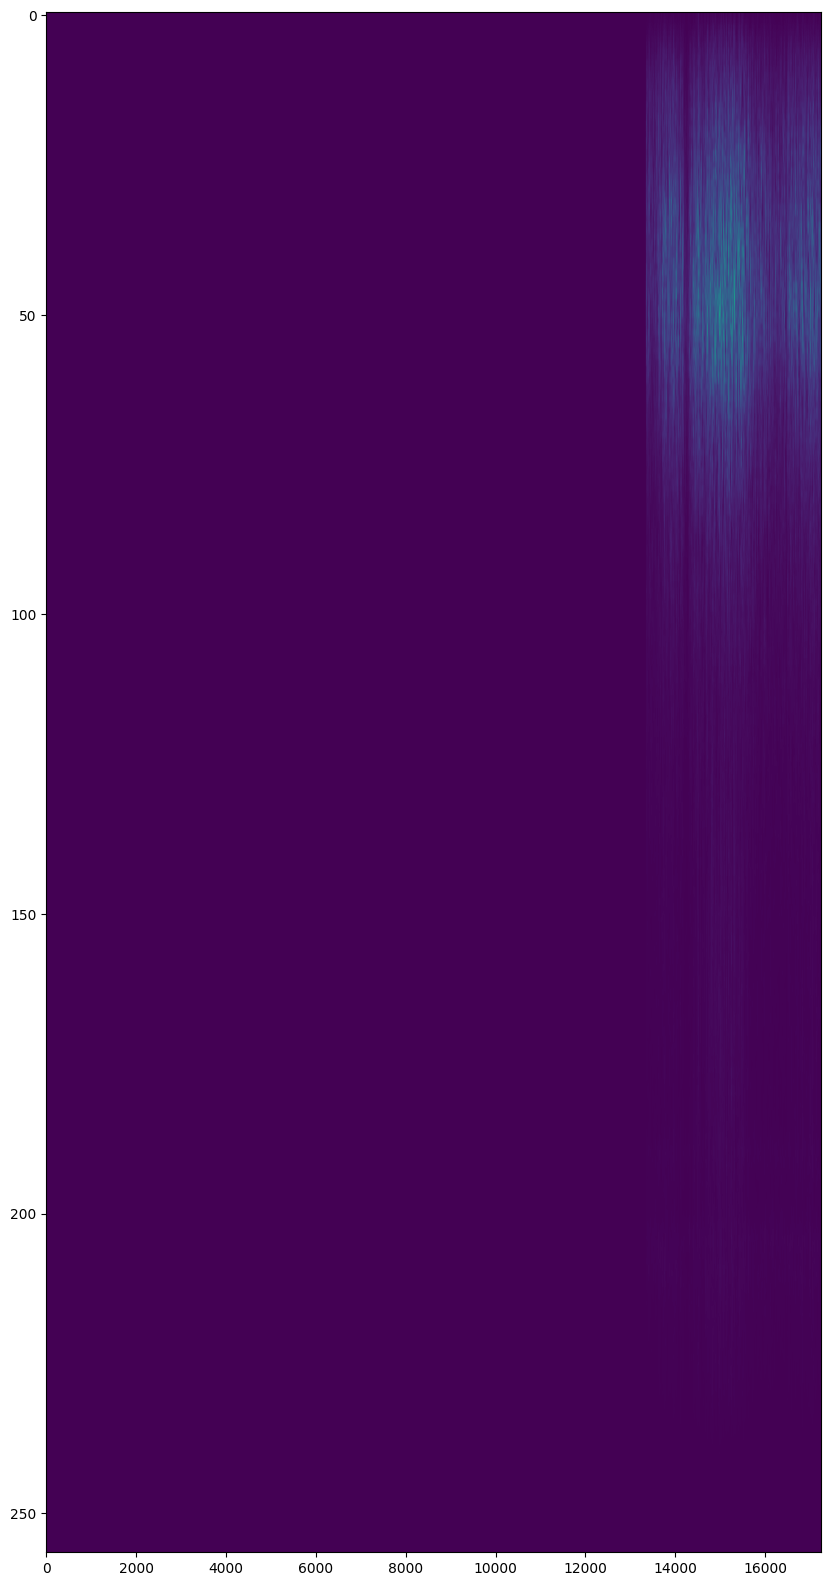

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(tf.transpose(spectrogram)[0], aspect='auto')
plt.show()

## 6. Create Training and Testing Partitions

### 6.1. Create a Tensorflow Data Pipeline

In [ ]:
data = combined_dataset.map(preprocessor)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(7)
data = data.prefetch(5)

In [ ]:
len(data)

5

### 6.2. Split into Training and Testing Partitions

In [ ]:
len(data)*.7

3.5

In [ ]:
train = data.take(4)
test = data.skip(4).take(1)

In [ ]:
train_features = train.map(lambda x, y: x)
train_labels = train.map(lambda x, y: y)

test_features = test.map(lambda x, y: x)
test_labels = test.map(lambda x, y: y)

In [ ]:
train_dataset = tf.data.Dataset.zip((train_features, train_labels))
test_dataset = tf.data.Dataset.zip((test_features, test_labels))

In [ ]:
train_dataset

<_ZipDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### 6.3. Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(7, 17243, 257, 1)

## Build Beep Learning Model

### 7.1. Load TensorFlow Dependencies

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

### 7.2. Build Sequential Model, Complile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(7, (3, 3), activation="relu", input_shape=(17243, 257, 1)))
model.add(Conv2D(7, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(4, activation="softmax"))

In [ ]:
model.compile("Adam", loss="CategoricalCrossentropy", metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17241, 255, 7)     70        
                                                                 
 conv2d_1 (Conv2D)           (None, 17239, 253, 7)     448       
                                                                 
 flatten (Flatten)           (None, 30530269)          0         
                                                                 
 dense (Dense)               (None, 32)                976968640 
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 976969290 (3.64 GB)
Trainable params: 976969290 (3.64 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7.3. Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train_dataset, epochs=4, validation_data=test_dataset)

Epoch 1/4


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible
